Importing Libraries

In [129]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler

## Loading the Dataset

In [130]:
# To upload from your local drive, start with the following code:
from google.colab import files
data = files.upload()

# Read csv data
data = pd.read_csv("loan_train.csv", usecols=range(2,10))
data.head()

Saving loan_train.csv to loan_train (1).csv


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


# 1. Dataset Preparation

## EDA

In [131]:
## Checking for data length and dtypes
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loan_status     346 non-null    object
 1   Principal       346 non-null    int64 
 2   terms           346 non-null    int64 
 3   effective_date  346 non-null    object
 4   due_date        346 non-null    object
 5   age             346 non-null    int64 
 6   education       346 non-null    object
 7   Gender          346 non-null    object
dtypes: int64(3), object(5)
memory usage: 21.8+ KB
None


In [132]:
## Checking for Null Values
print(data.isnull().sum()/len(data)*100)

loan_status       0.0
Principal         0.0
terms             0.0
effective_date    0.0
due_date          0.0
age               0.0
education         0.0
Gender            0.0
dtype: float64


In [133]:
## Checking for data summary statistics
print(data.describe())

         Principal       terms         age
count   346.000000  346.000000  346.000000
mean    943.641618   22.653179   30.939306
std     109.425530    7.991006    6.039418
min     300.000000    7.000000   18.000000
25%     900.000000   15.000000   27.000000
50%    1000.000000   30.000000   30.000000
75%    1000.000000   30.000000   35.000000
max    1000.000000   30.000000   51.000000


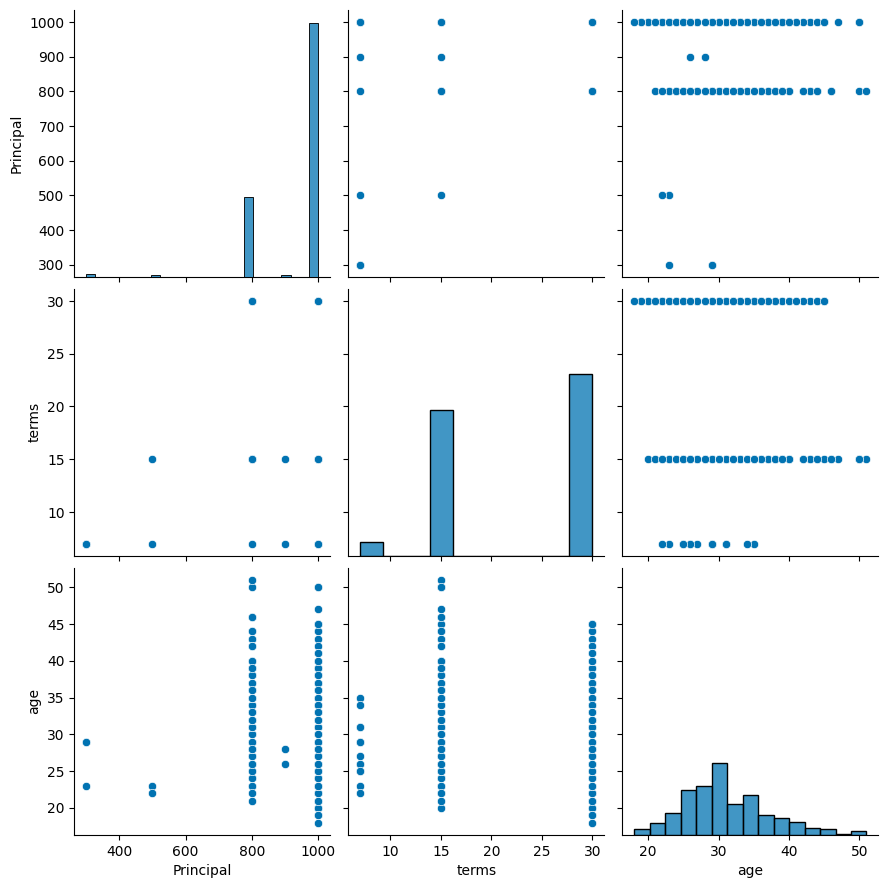

In [134]:
## Visualise Relationship between variables
sns.set_palette('colorblind')
sns.pairplot(data=data, height=3)

###Data Preprocessing

In [135]:
le_education = LabelEncoder() # labelencode for edu feature
le_Gender = LabelEncoder() # labelencode for gender feature
le_loan_status= LabelEncoder() # labelencode for loan status feature

In [136]:
data['edu_n'] = le_education.fit_transform(data['education'])
data['gender_n'] = le_Gender.fit_transform(data['Gender'])
data['loan_status_n'] = le_loan_status.fit_transform(data['loan_status'])

###Feature Engineering

In [137]:
## Creating a variable for the Days remaining for Payment
data['Days Remaining']=  (pd.to_datetime(data['due_date'])- pd.to_datetime(data['effective_date'])).dt.days

### Distribution of Variables

The value counts of the variables and thier distribution plots are used to check for outliers and skewness of the data.

skewness value should be within the range of -1 to 1 for a normal distribution, any major changes from this value indicates the presence of extreme value or outlier.

In [138]:
## Checking distribution of Loan Status, i.e. target variable
print(data['loan_status'].value_counts())

loan_status
PAIDOFF       260
COLLECTION     86
Name: count, dtype: int64


skewness value of Loan Status:  -1.1686985441445152


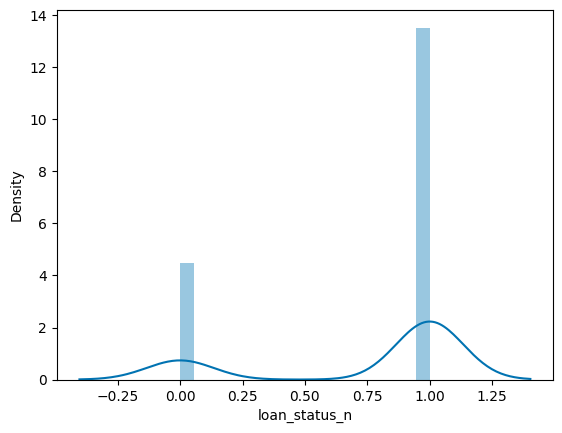

In [139]:
sns.distplot(data['loan_status_n'])
print('skewness value of Loan Status: ',data['loan_status_n'].skew())

skewness value of Terms:  -0.2689396361830413


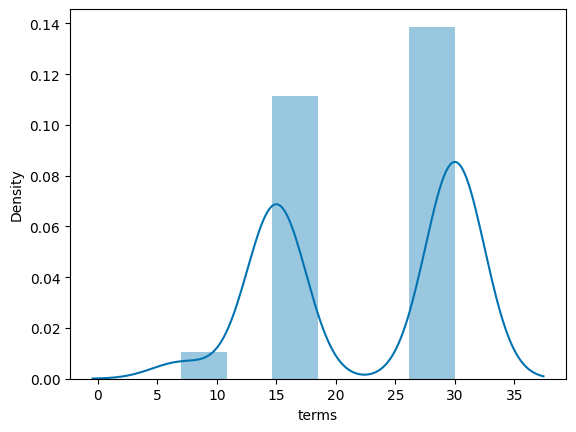

In [140]:
## Checking distribution of Terms
sns.distplot(data['terms'])
print('skewness value of Terms: ',data['terms'].skew())

skewness value of Age:  0.700410003463071


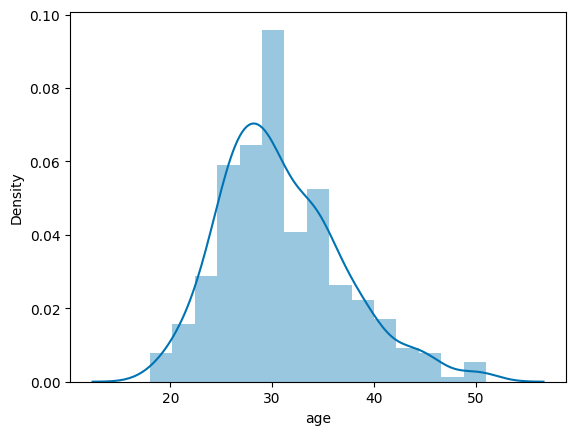

In [141]:
## Checking distribution of Age
sns.distplot(data['age'])
print('skewness value of Age: ',data['age'].skew())

In [142]:
## Checking distribution of education
print(data['education'].value_counts())

education
High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: count, dtype: int64


skewness value of Education:  0.010218165672620214


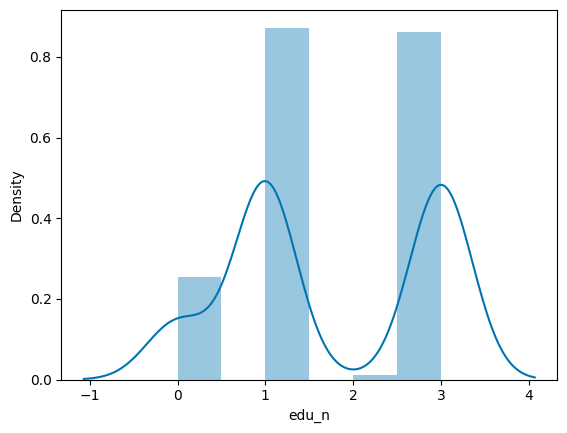

In [143]:
sns.distplot(data['edu_n'])
print('skewness value of Education: ',data['edu_n'].skew())

In [144]:
## Checking distribution of Gender
print(data['Gender'].value_counts())

Gender
male      294
female     52
Name: count, dtype: int64


skewness value of Gender:  -1.9657540690640292


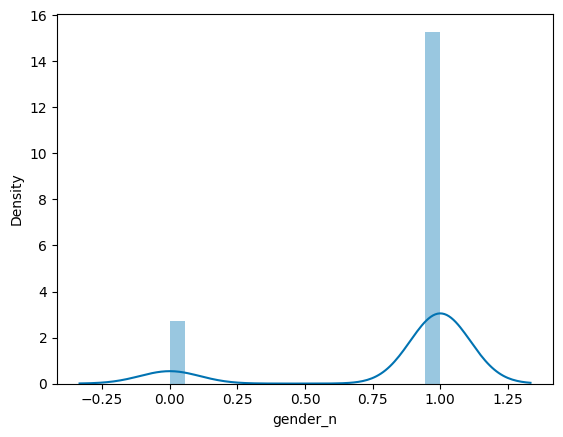

In [145]:
sns.distplot(data['gender_n'])
print('skewness value of Gender: ',data['gender_n'].skew())

skewness value of Principal:  -2.600235671644776


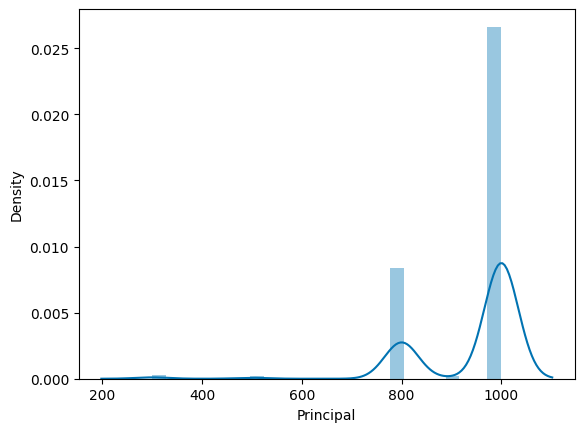

In [146]:
## Checking distribution of Principal
sns.distplot(data['Principal'])
print('skewness value of Principal: ',data['Principal'].skew())

From the above charts we could observed that Principal has the highest skewness among all and this highly skewed data also indiciates the presence of outliers on the left most side of the chart.

###Checking for Outliers

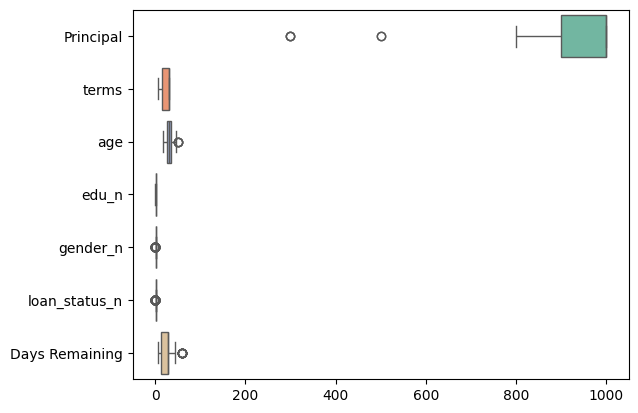

In [147]:
## Using Boxplot to visualise the Outliers
ax = sns.boxplot(data=data, orient="h", palette="Set2")

<Axes: ylabel='Principal'>

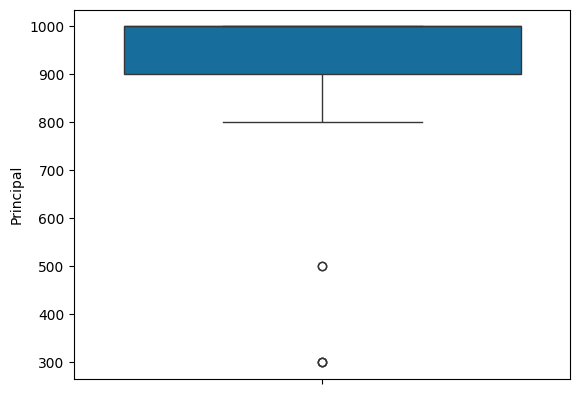

In [148]:
## Getting detailed view of outliers for Principal
sns.boxplot(data['Principal'])

In [149]:
## The the values for Principle at 99 percentile
print(data['Principal'].quantile(0.99))

1000.0


It is obsdrved that majority of the values for this variable lies above 1000. So, let's check for the count of values below 1000

In [150]:
#Data points with Principal less than 100
print(len(data[data['Principal']<1000]))

88


In [151]:
#Lets define the range as 10th and 90th percentile, given the data is highly skewed towards 1000, the values at 25th and 75th percentile are same.

Q1 = data['Principal'].quantile(0.10)
Q3 = data['Principal'].quantile(0.90)
IQR = Q3 - Q1
whisker_width = 1.5
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
data['Principal_']=np.where(data['Principal']>upper_whisker,upper_whisker,np.where(data['Principal']<lower_whisker,lower_whisker,data['Principal']))
print('Q1:',Q1, 'Q3:',Q3, 'IQR:',IQR)

Q1: 800.0 Q3: 1000.0 IQR: 200.0


Comparing the variable pre and post outlier treatment

<Axes: xlabel='Principal', ylabel='Density'>

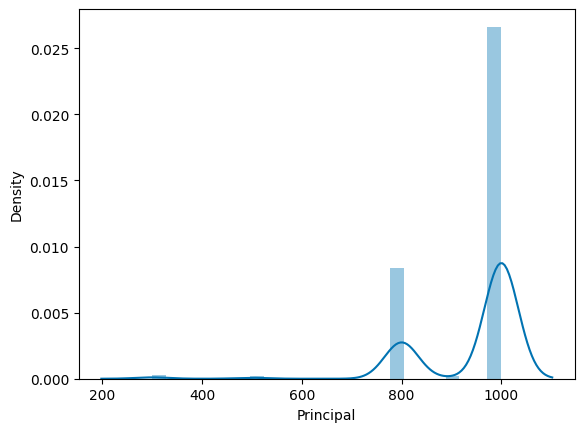

In [152]:
#Pre-scaling
sns.distplot(data['Principal'])

<Axes: xlabel='Principal_', ylabel='Density'>

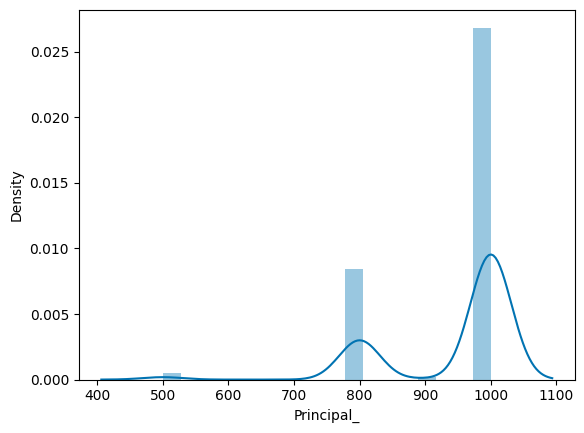

In [153]:
#Post-scaling
sns.distplot(data['Principal_'])

### Splitting Data into Target and Features

In [154]:
## Removing the columns which are not needed
inputs = data.drop(['loan_status','loan_status_n','education','Gender','due_date','effective_date','Principal'], axis='columns') # drop the target feature from the df
target = data['loan_status_n'] # create the target feature

### Scaling the input variables

(array([[346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,  81., 260.]]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <a list of 6 BarContainer objects>)

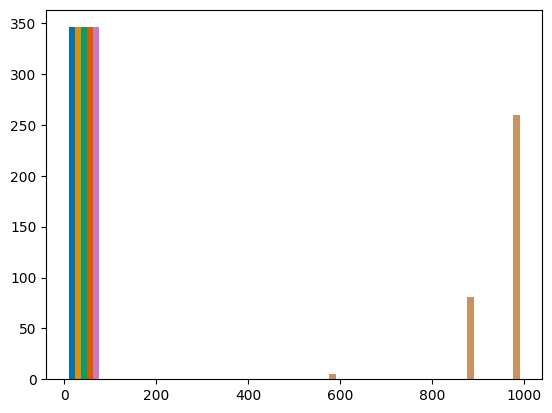

In [155]:
## Pre-scaled variable plot
plt.hist(inputs)

In [156]:
## Applying scaler to standardise the data
scaler = MinMaxScaler()
inputs[['Principal_', 'terms', 'age', 'Days Remaining']] = scaler.fit_transform(inputs[['Principal_', 'terms', 'age', 'Days Remaining']])

(array([[ 14., 148.,   0., 184.,   0.,   0.,   0.,   0.,   0.,   0.],
        [110., 188.,  44.,   4.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 44.,   0.,   0., 151.,   0.,   0.,   2.,   0.,   0., 149.],
        [ 52.,   0.,   0., 294.,   0.,   0.,   0.,   0.,   0.,   0.],
        [153., 176.,   5.,  12.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  5.,   0.,  83., 258.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 6 BarContainer objects>)

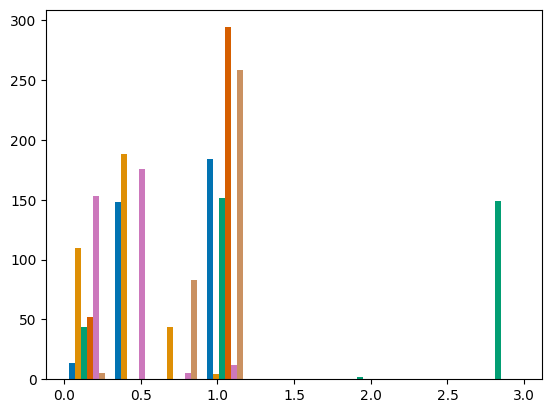

In [157]:
## Post-scaled variable plot
plt.hist(inputs)

## Train-Test Split

In [158]:
## Using 80-20 split for dividing Training and Test Data
X_train, X_test, y_train, y_test = train_test_split(
    inputs, target, test_size=0.20, random_state=42)

### Checking distribution of target varible in both train and test

In [159]:
## Distribution of Target on Training Data
print(y_train.value_counts(normalize=True))

loan_status_n
1    0.73913
0    0.26087
Name: proportion, dtype: float64


In [160]:
## Distribution of Target on Test Data
print(y_test.value_counts(normalize=True))

loan_status_n
1    0.8
0    0.2
Name: proportion, dtype: float64


# 2. Classification Algorithms

## **1 - Decision Trees**

In [161]:
## Defining the Decision Tree Classifier
DT = tree.DecisionTreeClassifier(class_weight={1:4,0:6})

Class weight is added in the above classifier due to imbalance classes. The target variable is not equally distributed between the two classes ( 0s and 1s)

In [162]:
## Fitting the Classifier
DT.fit(X_train.values, y_train)

DecisionTreeClassifier(class_weight={0: 6, 1: 4})

In [163]:
## Model Accuracy on the Test Sample
Score_DT=DT.score(X_test.values, y_test)
print(Score_DT)

0.6571428571428571


###Predictions on future observations

In [228]:
## Model Predictions
y_pred_DT = DT.predict(X_test)
print(y_pred_DT)

[1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0
 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0]


Text(58.222222222222214, 0.5, 'Truth')

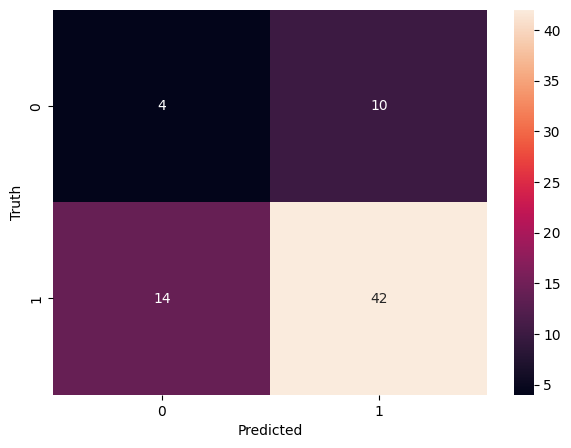

In [165]:
## Model Confusion Matrix
cm = confusion_matrix(y_test, y_pred_DT)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [166]:
## Model Classification Report
print(classification_report(y_test, y_pred_DT, target_names=['PAIDOFF','COLLECTION']))

              precision    recall  f1-score   support

     PAIDOFF       0.22      0.29      0.25        14
  COLLECTION       0.81      0.75      0.78        56

    accuracy                           0.66        70
   macro avg       0.51      0.52      0.51        70
weighted avg       0.69      0.66      0.67        70



##Hyperparameter tuning using Grid **Search**

In [167]:
## Grid-search for best parameter values
param_grid_decision_tree = {'criterion' : ['gini','entropy', 'log_loss'], 'splitter' : ['best', 'random'], 'max_depth' : [3,4,6,9], 'class_weight': [{1:2,0:4},{1:1,0:4},{1:1,0:1.5},{1:2,0:5}]}
grid_decision_tree = GridSearchCV(estimator=DT, param_grid=param_grid_decision_tree, scoring='accuracy')
grid_decision_tree.fit(X_train, y_train)
print(grid_decision_tree.best_params_)

{'class_weight': {1: 1, 0: 1.5}, 'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'}


In [168]:
## Defining the Classifier basis the best parameter identified in grid search
DT_optimised = tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 3, splitter= 'random', class_weight= {1: 1, 0: 1.5}, random_state=67)

In [169]:
## Fitting the classifier with tuned values
DT_optimised.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 1.5, 1: 1}, max_depth=3,
                       random_state=67, splitter='random')

In [170]:
## Model Accuracy of the tuned model on Test sample
Score_DT_optimised=DT_optimised.score(X_test,y_test)
print(Score_DT_optimised)

0.8


###Predictions on future observations

In [171]:
## Model Predictions of the tuned model on Test sample
y_pred_DT_optimised = DT_optimised.predict(X_test)
print(y_pred_DT_optimised)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Text(58.222222222222214, 0.5, 'Truth')

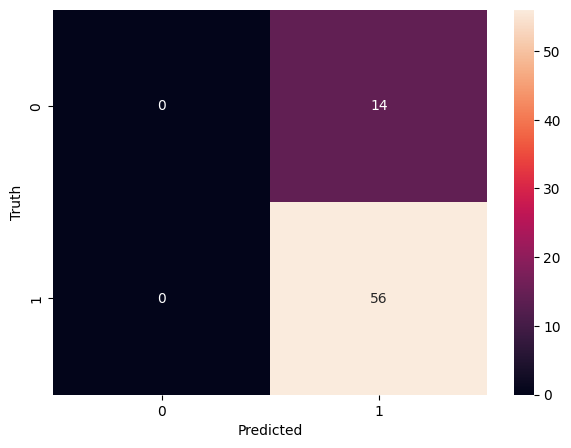

In [172]:
## Model Confusion Matrix of the tuned model
cm = confusion_matrix(y_test, y_pred_DT_optimised)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [173]:
## Model Classification Report of the tuned model
print(classification_report(y_test, y_pred_DT_optimised))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.80      1.00      0.89        56

    accuracy                           0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



## **2 - KNN**

In [174]:
## Defining the Knn Tree Classifier
knn = KNeighborsClassifier(n_neighbors=7,weights='distance')

In [175]:
## Fitting the Classifier
knn.fit(X_train.values, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [176]:
## Model Accuracy on the Test Sample
score_knn = knn.score(X_test,y_test)
print(score_knn)

0.6571428571428571


###Predictions on future observations

In [177]:
## Model Predictions
y_pred_knn = knn.predict(X_test)
print(y_pred_knn)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0]


Text(58.222222222222214, 0.5, 'Truth')

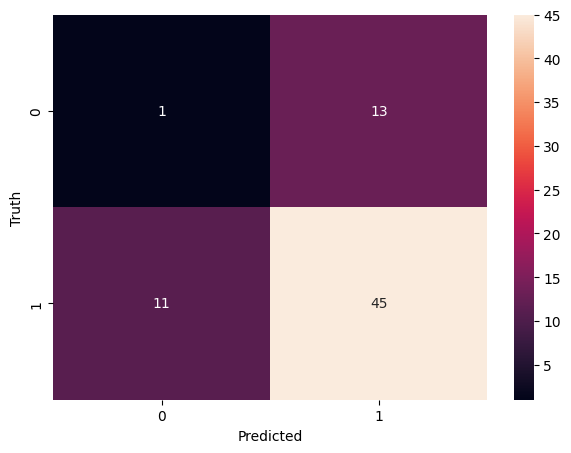

In [178]:
## Model Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [179]:
## Model Classification Report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.08      0.07      0.08        14
           1       0.78      0.80      0.79        56

    accuracy                           0.66        70
   macro avg       0.43      0.44      0.43        70
weighted avg       0.64      0.66      0.65        70



##Hyperparameter tuning using Grid Search

In [180]:
## Grid-search for best parameter values
param_grid_knn = {'n_neighbors': [2, 3, 5, 9],
         'weights': ['uniform', 'distance'],
         'leaf_size': [15, 20]}
grid_knn= GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring='accuracy')
grid_knn.fit(X_train, y_train)
print(grid_knn.best_params_)

{'leaf_size': 15, 'n_neighbors': 9, 'weights': 'uniform'}


In [181]:
## Defining the Classifier basis the best parameter identified in grid search
knn_optimised = KNeighborsClassifier(leaf_size = 15, n_neighbors = 9, weights= 'uniform')

In [182]:
## Fitting the classifier with tuned values
knn_optimised.fit(X_train,y_train)

KNeighborsClassifier(leaf_size=15, n_neighbors=9)

In [183]:
## Model Accuracy of the tuned model on Test sample
score_knn_optimised=knn_optimised.score(X_test,y_test)
print(score_knn_optimised)

0.7714285714285715


###Predictions on future observations

In [184]:
## Model Predictions of the tuned model on Test sample
y_pred_knn_optimised = knn_optimised.predict(X_test)
print(y_pred_knn_optimised)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Text(58.222222222222214, 0.5, 'Truth')

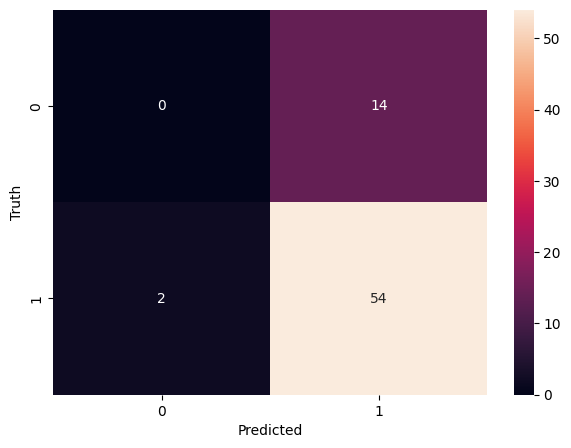

In [185]:
## Model Confusion Matrix of the tuned model
cm = confusion_matrix(y_test, y_pred_knn_optimised)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [186]:
## Model Classification Report of the tuned model
print(classification_report(y_test, y_pred_knn_optimised))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.79      0.96      0.87        56

    accuracy                           0.77        70
   macro avg       0.40      0.48      0.44        70
weighted avg       0.64      0.77      0.70        70



## **3 - SVC**

In [187]:
## Defining the SVC Classifier
svc = SVC(C=1, gamma=6, kernel='linear')

In [188]:
## Fitting the Classifier
svc.fit(X_train, y_train)

SVC(C=1, gamma=6, kernel='linear')

In [189]:
## Model Accuracy
svc.score(X_test, y_test)

0.8

###Predictions on future observations

In [190]:
## Model Predictions
y_pred_svc = svc.predict(X_test)

Text(58.222222222222214, 0.5, 'Truth')

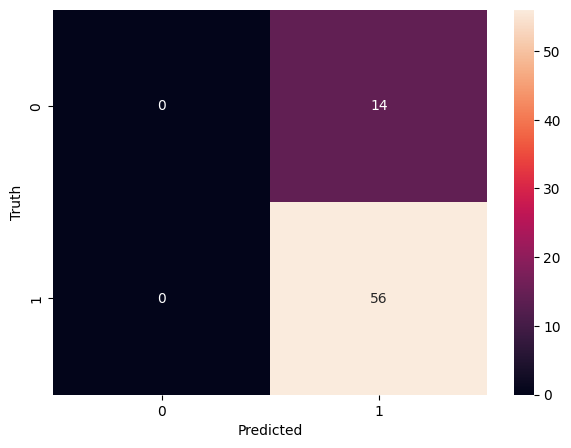

In [191]:
## Model Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [192]:
## Model Classification Report
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.80      1.00      0.89        56

    accuracy                           0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



## Hyperparamater Tuning using Grid Search

In [193]:
## Grid-search for best parameter values
param_grid_svc = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'class_weight': [{1:2,0:4},{1:1,0:4},{1:1,0:1.5},{1:2,0:5}]}
grid_svc= GridSearchCV(estimator=svc, param_grid=param_grid_svc, scoring='accuracy')
grid_svc.fit(X_train, y_train)
print(grid_svc.best_params_)

{'C': 0.1, 'class_weight': {1: 1, 0: 1.5}, 'gamma': 1}


In [194]:
## Defining the Classifier basis the best parameter identified in grid search
svc_optimised = SVC(C=.1, gamma=1, kernel='linear',class_weight={1: 1, 0: 1.5})

In [195]:
## Fitting the classifier with tuned values
svc_optimised.fit(X_train, y_train)

SVC(C=0.1, class_weight={0: 1.5, 1: 1}, gamma=1, kernel='linear')

In [196]:
## Model Accuracy of the tuned model on Test sample
score_svc_optimised = svc_optimised.score(X_test, y_test)
print(score_svc_optimised)

0.8


###Predictions on future observations

In [197]:
## Model Predictions of the tuned model on Test sample
y_pred_svc_optimised = svc_optimised.predict(X_test)
print(y_pred_svc_optimised)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Text(58.222222222222214, 0.5, 'Truth')

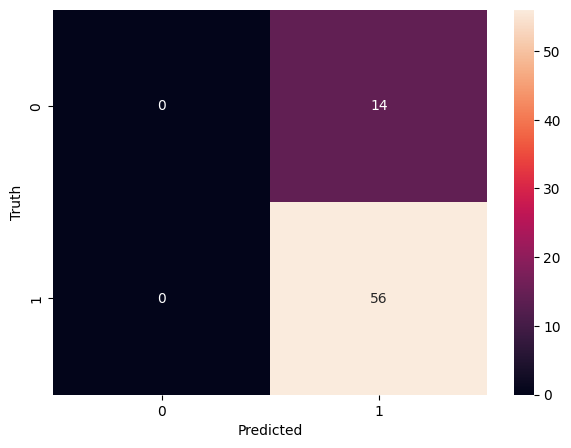

In [198]:
## Model Confusion Matrix of the tuned model
cm = confusion_matrix(y_test, y_pred_svc_optimised)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [199]:
## Model Classification Report of the tuned model
print(classification_report(y_test, y_pred_svc_optimised))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.80      1.00      0.89        56

    accuracy                           0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



## **4 - Naive Bayes**

In [200]:
## Defining the Gaussian Classifier
GNB = GaussianNB(var_smoothing=0.5)

In [201]:
## Fitting the Classifier
GNB.fit(X_train, y_train)

GaussianNB(var_smoothing=0.5)

In [202]:
## Model Accuracy
score_GNB=GNB.score(X_test, y_test)
print(score_GNB)

0.8


###Predictions on future observations

In [203]:
## Model Predictions
y_pred_GNB = GNB.predict(X_test)
print(y_pred_GNB )

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Text(58.222222222222214, 0.5, 'Truth')

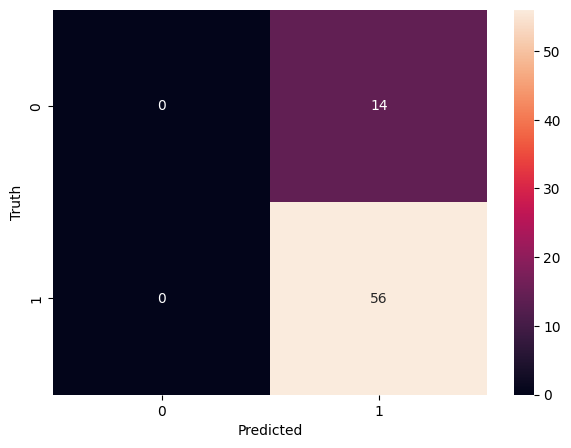

In [204]:
## Model Confusion Matrix
cm = confusion_matrix(y_test, y_pred_GNB)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [205]:
## Model Classification Report
print(classification_report(y_test, y_pred_GNB))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.80      1.00      0.89        56

    accuracy                           0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



## Hyperparamater Tuning using Grid Search

In [206]:
## Grid-search for best parameter values
param_grid_GNB = {'var_smoothing': [1e-2, 1e-5, 1e-8, 1e-11, 1e-14]}
grid_GNB= GridSearchCV(estimator=GNB, param_grid=param_grid_GNB, scoring='accuracy')
grid_GNB.fit(X_train, y_train)
print(grid_GNB.best_params_)

{'var_smoothing': 0.01}


In [207]:
## Defining the Classifier basis the best parameter identified in grid search
GNB_optimised = GaussianNB(var_smoothing=0.01)

In [208]:
## Fitting the classifier with tuned values
GNB_optimised.fit(X_train, y_train)

GaussianNB(var_smoothing=0.01)

In [209]:
## Model Accuracy of the tuned model on Test sample
score_GNB_optimised=GNB_optimised.score(X_test, y_test)
print(score_GNB_optimised)

0.6857142857142857


###Predictions on future observations

In [210]:
## Model Predictions of the tuned model on Test sample
y_pred_GNB_optimised = GNB_optimised.predict(X_test)
print(y_pred_GNB_optimised)

[1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0]


Text(58.222222222222214, 0.5, 'Truth')

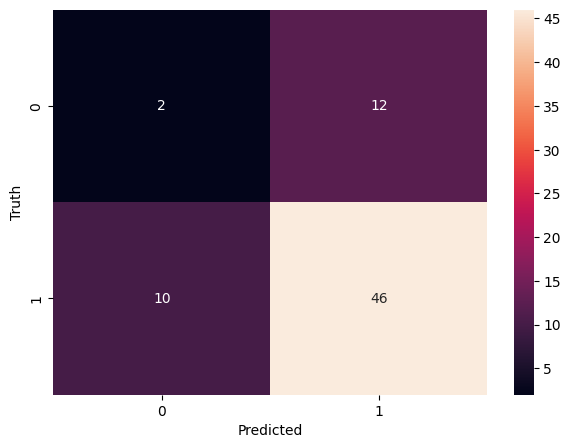

In [211]:
## Model Confusion Matrix of the tuned model
cm = confusion_matrix(y_test, y_pred_GNB_optimised)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [212]:
## Model Classification Report of the tuned model
print(classification_report(y_test, y_pred_GNB_optimised))

              precision    recall  f1-score   support

           0       0.17      0.14      0.15        14
           1       0.79      0.82      0.81        56

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.67      0.69      0.68        70



# 5. Ensemble Learning

###Bagging DT Classifier

Training a Decision Tree Classifier using the bagging technique

In [213]:
from sklearn.ensemble import BaggingClassifier

In [214]:
## Defining the Bagging classifier using Decision Tree as an Estimator
bagging_DT = BaggingClassifier(estimator=tree.DecisionTreeClassifier(),
                        n_estimators=10, random_state=0).fit(X_train, y_train)

In [215]:
## Model Accuracy
score_bagging_DT=bagging_DT.score(X_test, y_test)
print(score_bagging_DT)

0.7285714285714285


###Predictions on future observations

In [216]:
## Model Predictions
y_pred_bagging_DT = bagging_DT.predict(X_test)
print(y_pred_bagging_DT)

[1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


Text(58.222222222222214, 0.5, 'Truth')

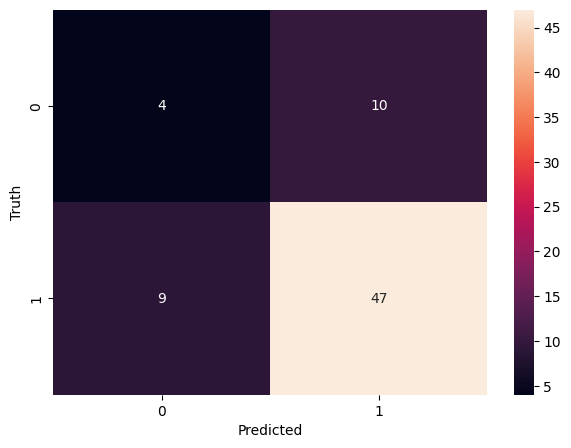

In [217]:
## Model Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bagging_DT)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [218]:
## Model Classification Report
print(classification_report(y_test, y_pred_bagging_DT))

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        14
           1       0.82      0.84      0.83        56

    accuracy                           0.73        70
   macro avg       0.57      0.56      0.56        70
weighted avg       0.72      0.73      0.72        70



###Random Forest Classifier

Using a Random Forest classfier to compare results with Bagging DT

In [219]:
## Defining the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=2, random_state=0)

In [220]:
## Fitting the Classifier
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [221]:
## Model Accuracy
score_RF=RF.score(X_test,y_test)
print(score_RF)

0.8


###Predictions on future observations

In [222]:
## Model Predictions
y_pred_RF = RF.predict(X_test)
print(y_pred_RF)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Text(58.222222222222214, 0.5, 'Truth')

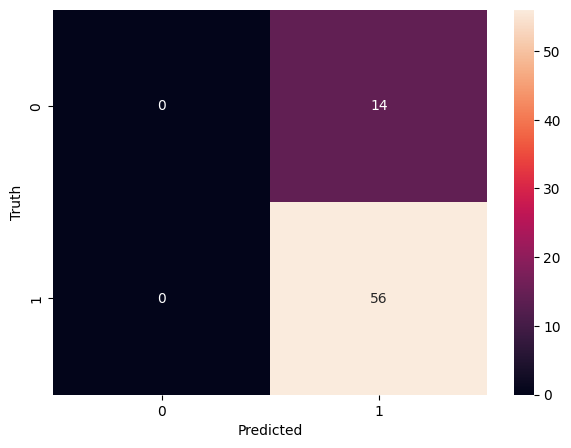

In [223]:
## Model Confusion Matrix
cm = confusion_matrix(y_test, y_pred_RF)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [224]:
## Model Classification Report
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.80      1.00      0.89        56

    accuracy                           0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



##1. Accuracy
The Bagging (Decision Tree) classifier provides a lower accuracy (72%) when compared with the Random Forest classifier (80%).

##2. Strengths vs Weaknesses
2.1. Bagging with Decision Trees

Strengths
1. Less Overfitting as the model is trained by creating multiple decision tress using different daya subsets

2. Given less overfitting, it provides more stability of results and therefore is more reliable when using differmt data points.

Weaknesses
1. It is computationally intesive, so requires a lot of memory when running on a large dataset, though it is not a problem in the current use case with less than 400 rows.

2. May not work as well on the comlex datasets with multiple features.

2.2. Random Forest Classifier

Strengths
1. Given it is a combination of random sampling and randomized feature selection, this method also reduces the risk of overfitting.

2. Works well with complex and large databases when compared to the Bagging classiifier.

Weaknesses
1. May not work well for simpler models with less complex features.

2. Computationally intensive as it an esemble of multiple decision trees

# 6. Future Predictions

most performant model.
predictions on future observations
insights into its practical application

In [225]:
metrics_1 = {'Model': 'Decision Tree Classifier', 'Accuracy': Score_DT_optimised}
metrics_2 = {'Model': 'K Neighbours Classifier', 'Accuracy': score_knn_optimised}
metrics_3 = {'Model': 'Support Vector Classifier', 'Accuracy': score_svc_optimised}
metrics_4 = {'Model': 'Gaussian Classifier ', 'Accuracy': score_GNB_optimised}
metrics_5 = {'Model': 'Bagging Decision Tree Classifier', 'Accuracy': score_bagging_DT}
metrics_6 = {'Model': 'Random Forest Classifier', 'Accuracy': score_RF }
# Collect the metrics into a list (one entry for each model)
all_metrics = [metrics_1, metrics_2, metrics_3, metrics_4,metrics_5,metrics_6]

# Convert the list of dictionaries into a pandas DataFrame
metrics_df = pd.DataFrame(all_metrics).sort_values(['Accuracy'], ascending=False)
print(metrics_df)

                              Model  Accuracy
0          Decision Tree Classifier  0.800000
2         Support Vector Classifier  0.800000
5          Random Forest Classifier  0.800000
1           K Neighbours Classifier  0.771429
4  Bagging Decision Tree Classifier  0.728571
3              Gaussian Classifier   0.685714


From the 6 classification models explored above, we can clearly observe that Decision Tree Classifier,Support Vector Classifier and Random Forest Classifier have the highest accuracy of 80% on Test Sample. Therefore, these 3 are the best performer models and the Naive Bayes or Gaussian Classifier is the worst performing model in the given use case.

###Practical Applications

The banks/financial institutions can use this information to plan the collection efforts and also to predict the default on a loan.

The information on the Loans with the Status predicted to be - Collection, can be used to calculate the Provision by the banks. More predicted collections means more chances of loan defaults, implying higher provsional requirements.